#Import peckage

In [1]:
!pip install nltk

In [2]:
!pip install PySastrawi

In [3]:
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from collections import Counter
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
tqdm.pandas()
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras import Sequential
from keras.layers import LSTM

from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2

from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

#Load Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Bootcamp NLP Batch 3 Indonesia AI/Project 1: Sentiment Analysis/tweet.csv')
df = df[['sentimen','tweet']]
df.head()

,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...


#onehot encoding

In [5]:
# Perform one-hot encoding on the 'sentiment' column
encoder = OneHotEncoder(sparse=False)
sentiments_onehot = encoder.fit_transform(df[['sentimen']].values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
sentiments_onehot

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

#Cek Distribusi Sentimen Positif, Negatif, dan Netral

In [ ]:
df['sentimen'].value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

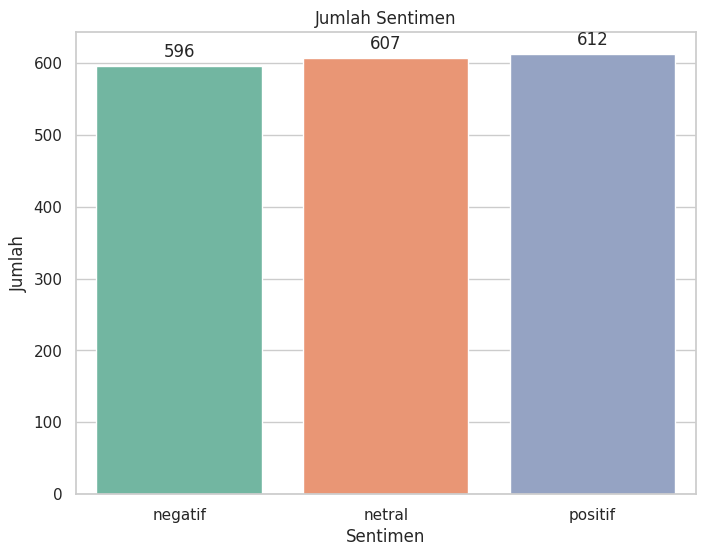

In [ ]:
# Membuat bar chart menggunakan Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
barplot = sns.countplot(x="sentimen", data=df, palette="Set2")

# Menambahkan label pada bar chart
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')

# Menampilkan bar chart
plt.title("Jumlah Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

#Convert Label Sentimen

In [ ]:
# Labeling Label dataset
label_encoder = preprocessing.LabelEncoder()
df['sentimen'] = label_encoder.fit_transform(df['sentimen'])
df.head()

,sentimen,tweet
0,0,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,1,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,2,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,0,Negara kita ngutang buat bngun infrastruktur y...


#Preprocessing

##Load Alay Dict

In [ ]:
#load alay corpus
alay_dict = pd.read_csv('/content/drive/MyDrive/Bootcamp NLP Batch 3 Indonesia AI/Project 1: Sentiment Analysis/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original',
                                      1: 'replacement'})

In [ ]:
alay_dict.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


##Load Indonesia Stopword

In [ ]:
#Indonesia Stopword
id_stopword_dict = pd.read_csv('/content/drive/MyDrive/Bootcamp NLP Batch 3 Indonesia AI/Project 1: Sentiment Analysis/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

In [ ]:
id_stopword_dict.head()

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


##Case Folding

In [ ]:
def lowercase(text):
    return text.lower()

##Remove unnecessary char

In [ ]:
def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

##remove_nonaplhanumeric

In [ ]:
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

##remove_number

In [ ]:
def remove_number(text):
  text_number = re.sub(r'\d+','',text)
  return text_number

##normalize_alay

In [ ]:
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

##remove_stopword

In [ ]:
def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text


##stemming

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return stemmer.stem(text)

In [ ]:
print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa!!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("stemming: ", stemming("Perekonomian Indonesia sedang dalam pertumbuhan yang membanggakan"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))
print("remove_stopword: ", remove_stopword("ada hehe adalah huhu yang hehe"))
print("remove_number: ", remove_number("prabowo presiden 2024"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
stemming:  ekonomi indonesia sedang dalam tumbuh yang bangga
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe
normalize_alay:  amin adik habis
remove_stopword:  hehe huhu hehe
remove_number:  prabowo presiden 


##Typo Corection

In [ ]:
kbbi = pd.read_csv('https://raw.githubusercontent.com/Hidayathamir/kata-kbbi-github/main/kbbi.csv')
WORDS = Counter(kbbi['kata'].to_list())

def P(word, N=sum(WORDS.values())):
    "Probability of `word`."
    return WORDS[word] / N

def correction(word):
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word):
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [ ]:
typo = 'pekerjasn'
correction(typo)

'pekerjaan'

##Apply Preprocessing

In [ ]:
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 3
    text = remove_number(text)#4
    text = normalize_alay(text) # 5
    text = correction(text) # 6
    text = stemming(text) # 7
    text = remove_stopword(text) # 8
    return text

In [ ]:
df = df[:50]

In [ ]:
df.head()

,sentimen,tweet
0,0,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,1,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,2,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,0,Negara kita ngutang buat bngun infrastruktur y...


In [ ]:
df['tweet_preprocess'] = df['tweet'].progress_apply(lambda x: preprocess(x))

#TF-IDF

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Bootcamp NLP Batch 3 Indonesia AI/Project 1: Sentiment Analysis/data_preprocessing.csv')

In [8]:
df.head()

,sentimen,tweet,tweet_preprocess
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,prabowo indonesia harga bangsa asing berita ho...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batu langka tasbih jokowi hadiah habib luthfi ...
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia pic twitter com w...
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asi games dampak pd ekonomi l...
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang bngun infrastruktur udah dipake...


In [9]:
# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tweet_preprocess'])

In [10]:
print(tfidf_matrix.shape)

(1815, 5469)


In [11]:
Y = sentiments_onehot

#Split Data

In [12]:
# Membagi data menjadi data pelatihan, data sisa, dan data validasi
X_train, X_temp, y_train, y_temp = train_test_split(tfidf_matrix, Y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
# Ubah matriks TF-IDF menjadi matriks sparse dokumen-terkompresi
X_train = X_train.toarray()
X_test = X_test.toarray()
X_val = X_val.toarray()

#LSTM Model

In [14]:
# Tentukan panjang sekuens input LSTM (misalnya, sesuai dengan panjang maksimum dari TF-IDF)
max_len = X_train.shape[1]
max_words = X_train.shape[0]

In [15]:
# define RNN
def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.3)(layer)
    layer = Dense(3,name='out_layer', kernel_regularizer=l2(0.01))(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [16]:
model = RNN()
model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5469)]            0         
                                                                 
 embedding (Embedding)       (None, 5469, 50)          63500     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 3)                 771   

In [17]:
model_history= model.fit(X_train, y_train,batch_size=512, epochs=100, validation_data=(X_val, y_val),
                         callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Epoch 1/100
3/3 [==============================] - 131s 32s/step - loss: 1.1592 - accuracy: 0.3244 - val_loss: 1.1570 - val_accuracy: 0.3004
Epoch 2/100
3/3 [==============================] - 103s 35s/step - loss: 1.1551 - accuracy: 0.3378 - val_loss: 1.1545 - val_accuracy: 0.3443
Epoch 3/100
3/3 [==============================] - 95s 29s/step - loss: 1.1521 - accuracy: 0.3394 - val_loss: 1.1525 - val_accuracy: 0.3443
Epoch 4/100
3/3 [==============================] - 98s 32s/step - loss: 1.1493 - accuracy: 0.3370 - val_loss: 1.1500 - val_accuracy: 0.3443
Epoch 5/100
3/3 [==============================] - 92s 30s/step - loss: 1.1453 - accuracy: 0.3528 - val_loss: 1.1469 - val_accuracy: 0.3443
Epoch 6/100
3/3 [==============================] - 96s 32s/step - loss: 1.1431 - accuracy: 0.3449 - val_loss: 1.1439 - val_accuracy: 0.3443
Epoch 7/100
3/3 [==============================] - 95s 29s/step - loss: 1.1402 - accuracy: 0.3299 - val_loss: 1.1406 - val_accuracy: 0.3443
Epoch 8/100
3/3 [=

In [18]:
# Evaluasi model pada data pengujian
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

9/9 [==============================] - 9s 1s/step - loss: 1.1069 - accuracy: 0.2757
Test Loss: 1.107
Test Accuracy: 0.276


In [19]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

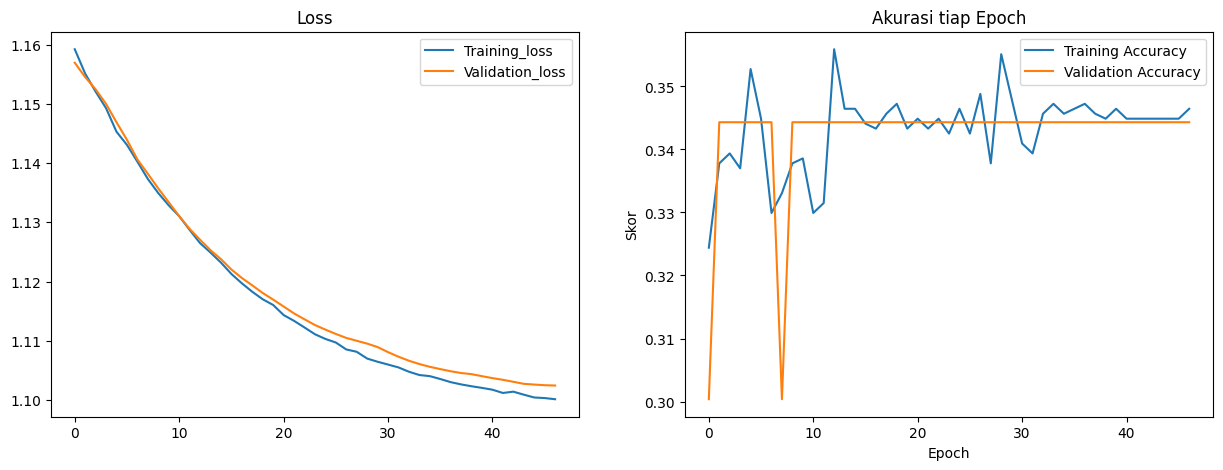

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Loss')
ax[0].plot(model_history.epoch, model_history.history["loss"], label="Training_loss")
ax[0].plot(model_history.epoch, model_history.history["val_loss"], label="Validation_loss")
plt.xlabel("Epoch")
plt.ylabel("Skor Loss")
ax[1].set_title('Akurasi tiap Epoch')
ax[1].plot(model_history.epoch, model_history.history["accuracy"], label="Training Accuracy")
ax[1].plot(model_history.epoch, model_history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Skor")

ax[0].legend()
ax[1].legend()

#Random Forest

In [21]:
# Inisialisasi model Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Latih model Random Forest dengan data pelatihan
random_forest.fit(X_train, y_train)

# Prediksi sentimen pada data validasi
y_val_pred = random_forest.predict(X_val)

In [22]:
# Evaluasi model pada data validasi
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f'Accuracy on validation data: {accuracy_val:.2f}')

# Prediksi sentimen pada data pengujian
y_test_pred = random_forest.predict(X_test)

# Evaluasi model pada data pengujian
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on test data: {accuracy_test:.2f}')

Accuracy on validation data: 0.42
Accuracy on test data: 0.38


In [23]:
# Menampilkan laporan klasifikasi pada data pengujian
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.55      0.54      0.54        85
           1       0.64      0.43      0.51        75
           2       0.81      0.23      0.36       112

   micro avg       0.63      0.38      0.47       272
   macro avg       0.67      0.40      0.47       272
weighted avg       0.68      0.38      0.46       272
 samples avg       0.38      0.38      0.38       272



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
